# Kaggle's [*Titanic: Machine Learning from Disaster Competition*](https://www.kaggle.com/c/titanic)

## Table of Contents:

## Summary

The goal of this Kaggle competition was to train a model to correctly predict whether a passenger on the Titanic survived or not. After feature selection and running various classification algorithms I elected to use a Gradient Boosting Classification algorithm implemented in Scikit-Learn. My algorithm scored 0.76794.

There are multiple ways I could have improved my score; however, the goal of this project for myself was to not have the best model. In R I scored a 0.78708. Rather, the goal of this project was to become more familiar with the Python syntax and gain experience in Scikit-Learn, Matplotlib, and the Seaborn libraries for both model building and data exploration.

## 2. Data Exploration

### 2.1 Install libraries and import data

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [192]:
training = pd.read_csv('/Users/Nick/Data_Science/Kaggle/titanic_python/data/train.csv')
testing = pd.read_csv('/Users/Nick/Data_Science/Kaggle/titanic_python/data/test.csv')

# Create the Survived column for the testing data (not included in the downloaded set)
testing['Survived'] = np.nan

# Create a dummy variable to show if the data is training or testing data
testing['training'] = False
training['training'] = True

# Combine the training and testing data for data exploration
full = training.append(testing, sort=True)

# Clean dataframes
full.columns = full.columns.str.lower()
full.reset_index(drop=True, inplace=True)

Now that the data is downloaded let us start by doing some basic exploration of our full dataframe. First, let us look at the data types of our variables and see where missing values are.

In [193]:
full.head()

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,training
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,True
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,True
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,True
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,True
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,True


In [194]:
full.dtypes

age            float64
cabin           object
embarked        object
fare           float64
name            object
parch            int64
passengerid      int64
pclass           int64
sex             object
sibsp            int64
survived       float64
ticket          object
training          bool
dtype: object

### 2.2 Missing Data

In [195]:
full.isna().sum()

age             263
cabin          1014
embarked          2
fare              1
name              0
parch             0
passengerid       0
pclass            0
sex               0
sibsp             0
survived        418
ticket            0
training          0
dtype: int64

In [196]:
full.isna().mean().round(2)

age            0.20
cabin          0.77
embarked       0.00
fare           0.00
name           0.00
parch          0.00
passengerid    0.00
pclass         0.00
sex            0.00
sibsp          0.00
survived       0.32
ticket         0.00
training       0.00
dtype: float64

Looking at the missing values in our dataframe we see the highest value is `cabin` at 1014 missing values. This accounts for around 77%. To keep things simple, we will just drop this feature from our dataframe.

The `survived` feature has the most missing values at 418 (~32%). This makes sense as we created the missing values in the previous code block since the testing data from Kaggle did not have a `survived` variable.  

Next, `age` has 263 missing values (20%). Age is definitely something we will want to include in our model. Later, we will use an imputation function from Scikit-Learn to fill the missing values.

Finally, we have 2 missing values for the `embarked` location and 1 missing value for the `fare` value. Let's first take a look at the 2 missing values for the embarked location.

In [197]:
full[full.embarked.isna()]

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,training
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,True
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,True


Miss Amelie Icard and Mrs. Martha Evelyn Stone are missing their embarked location. According to some research, Miss Icard was Mrs. Stone's personal maid and they boarded together at Southampton.

In [198]:
full.loc[full.embarked.isna() == True, 'embarked'] = 'S'

In [199]:
full[full.fare.isna() == True]

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,training
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,False


As shown above, the fare infomration for Mr. Thomas Storey is missing. After some research it appears that Mr. Storey was a member of the ship's crew who boarded in Southampton. Let us look at  similar passengers (single males who boarded at Southhampton) to gather an idea of what a likely ticket price Thomas would've paid.

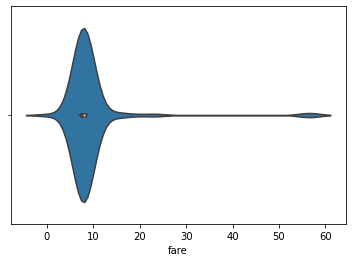

The median fare for passengers similar to Thomas: 7.89
The mean fare for passengers similar to Thomas: 9.25


In [200]:
similar_passengers = full[(full.sex == 'male') & (full.parch == 0) & (full.sibsp == 0) & (full.pclass == 3)]
sns.violinplot(x='fare', data=similar_passengers)
plt.show()
similar_passengers_median = similar_passengers.fare.median()
print('The median fare for passengers similar to Thomas: ' + str(round(similar_passengers_median, 2)))
similar_passengers_mean = similar_passengers.fare.mean()
print('The mean fare for passengers similar to Thomas: ' + str(round(similar_passengers_mean, 2)))

The above violin plot shows that for passengers of a similar class, boarding, travel companions, and sex to Thomas the distributions of fares is heavily concentrated under 10, but has some outliers (perhaps last-second purchases). As such, we will use the median for Thomas's fare. The mean/average is skewed by those significantly higher prices.

In [201]:
full.loc[full.fare.isna() == True, 'fare'] = similar_passengers_median

### 2.3 Feature Creation

Next, let us create some new features. One feature that potentially has some useful information in it is the `name` column. Each name possesses a title/salutation that we can extract out.

In [202]:
title = full.name.str.partition('.', True)[0]
full['title'] = title.str.split().str.get(-1)

full.title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Dona          1
Mme           1
Don           1
Capt          1
Jonkheer      1
Sir           1
Countess      1
Name: title, dtype: int64

There are a lot of different title and some of them are very unique (only 1-2 occurances). Instead of looking at all these unique values we will bin them together based on common categories.

In [203]:
title_groups = {'Mr': 'Mr', 
                'Sir':['Master', 'Dr', 'Rev', 'Don', 'Sir', 'Jonkheer'],
                'Miss':['Miss', 'Mrs', 'Ms', 'Mlle', 'Mme'],
                'Madam':['Countess', 'Dona','Lady'],
                'Military':['Col', 'Capt', 'Major']}

full["title"] = (
    full["title"]
    .apply(lambda x: [k for k in title_groups.keys() if x in title_groups[k]])
    .str[0]
    .fillna("Other")
)

full.drop(columns = 'name', inplace=True)

Another feature that we will change is the age variable. Instead of focusing on the specific age, we will bin the ages into groups. This will make it easier to identify trends among general age ranges.

In [204]:
full['age_binned'] = pd.cut(x=full['age'], bins = [0, 2, 10, 19, 29, 39, 49, 59, 69, 79, 89], 
                                labels=['Toddler', 'Child', 'Teen', '20s', '30s', '40s', '50s', '60s', '70s', '80s'])

Finally, we will create is family size. The `parch` and `sibsp` variables tell us the number of parents and siblings each passenger had onboard. Instead of evaluating these separately we will combine them together into a single variable. In order to save a step later, we will also drop the `passengerid` variable as it just serves to identify each passenger in the dataset. Additionally, we will drop the `cabin` variable. It has too many missing values to add any value to our model at this point.

In [205]:
full['fsize'] = full['sibsp'] + full['parch'] + 1
full.drop(columns = ['sibsp','parch','passengerid'], inplace=True)
full.drop(columns = 'cabin', inplace=True)

### 2.4 Data Exploration and Variable Comparison

Now with our data cleaned up and missing values - except missing ages - filled in we will do some data exploration. In order to ensure that our model is built entirely upon the training data and the testing data is held out until the end (to avoid overfitting and cheating on the competition), we will just be exploring the training data.

One of my hypotheses going into the project was that women and children would have a higher survival rate based on the old maritime adage of "women and children first."

sex     survived
female  1.0         0.742038
        0.0         0.257962
male    0.0         0.811092
        1.0         0.188908
Name: survived, dtype: float64


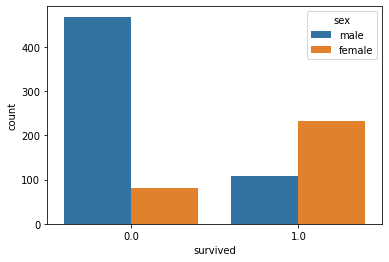

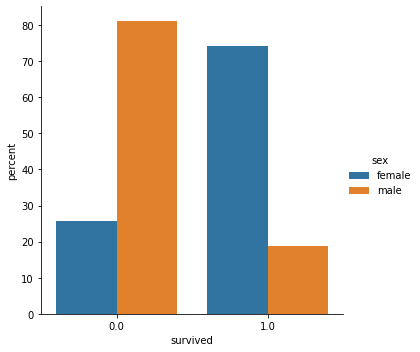

In [206]:
testing = full[full.training == False]
training = full[full.training == True]


print(training.groupby('sex')['survived'].value_counts(normalize=True))

sns.countplot(x='survived', hue='sex', data=training)

(training
.groupby('sex')['survived']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='survived',y='percent',hue='sex',kind='bar'))

Women had a much higher likelihood for surviving than men with over 80% of men dying compared to ~25% for women. What about age? Is there a pattern between survival based on age?

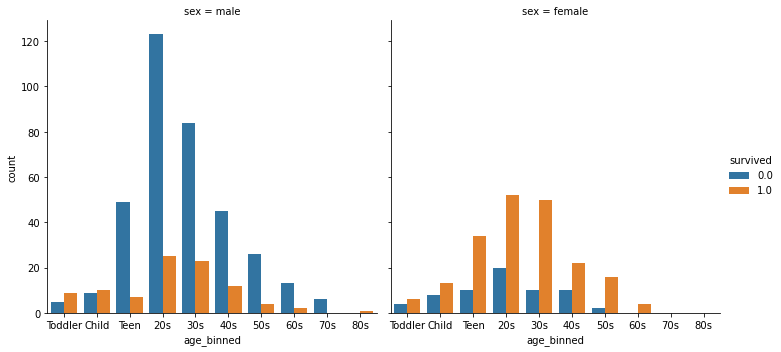

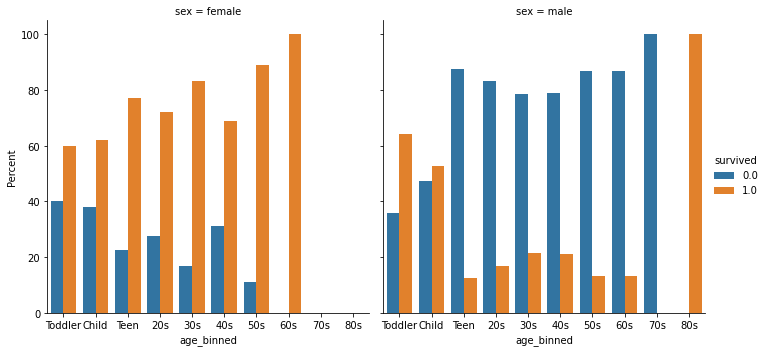

In [207]:
sns.catplot('age_binned', 
              hue='survived', 
              data=training, 
              col='sex',
              kind='count')

(training
.groupby(['sex', 'age_binned'])['survived']
.value_counts(normalize=True)
.mul(100)
.rename('Percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='age_binned',y='Percent',hue='survived',col='sex',kind='bar'))

For females the above graphs might come across as a little misleading initially. It appears that toddlers and children actually have the highest non-survival rate. However, on a nominal level they are very low (<10), meaning their rates are skewed by one or two deaths. In reality, there does not seem to be a distinguishable pattern with women. Most age bins had mortality rates ranging from 20-40% which is inline with the survival rate for all women.

For males it is a different story. There is a clear jump in the survival rates for young males (toddlers and children). However, once we start looking at teens the survival rate drops to below 20% which is inline with the survival rate for all men.

Looking at the data visually, it appears that females did have a higher survival rate. While males died at a higher rate, there was a higher survival rate for toddlers and children.

My other hypothesis was that there would be some positive relationship between wealth and survival. While the wealth is not explicitly given in the data we can use passenger class `pclass` and ticket fare `fare` as a proxy.

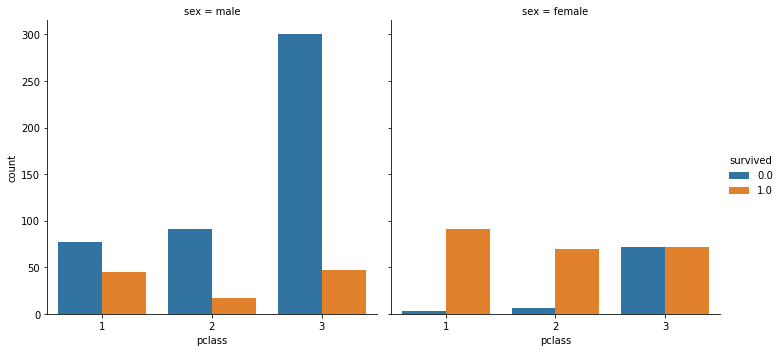

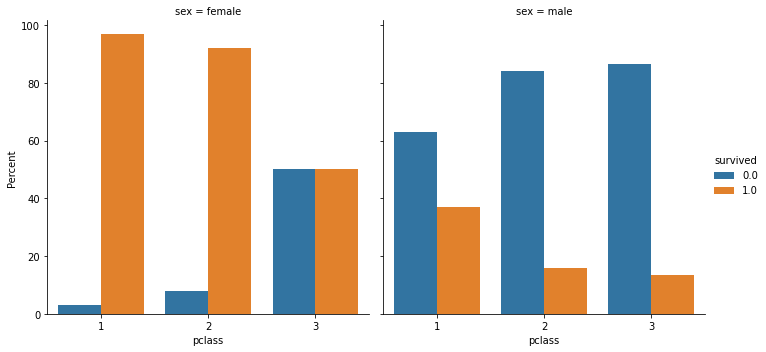

In [208]:
sns.catplot('pclass', 
              hue='survived', 
              data=training, 
              col='sex',
              kind='count')

(training
.groupby(['sex', 'pclass'])['survived']
.value_counts(normalize=True)
.mul(100)
.rename('Percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='pclass',y='Percent',hue='survived',col='sex',kind='bar'))

According to the graphs, there is a fairly strong relationship between passenger class and survival. The overwhelming majority of passengers that died were 3rd class males (they were also the largest total category too). On a percentage basis both males and females show higher death rates in the higher classes. This is most evident in 3rd class women; where, the death rate is ~50%, significantly higher than ~25% death rate for all women.

Let's dig into fares. First lets gain a better understanding of fares. The obvious guess is that fares are associated with class (e.g. higher classes equals higher fares). Let's confirm that.

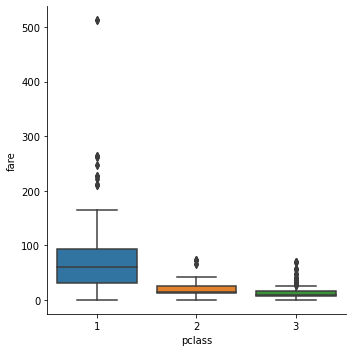

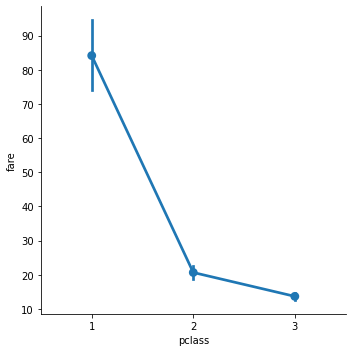

In [209]:
sns.catplot(x='pclass', y='fare', data=training, kind='box')
sns.catplot(x='pclass', y='fare', data=training, kind='point')

While there is some overlap among outliers, there is a clear negative relationship between prices and passenger class. Lower classes (2nd and 3rd) have significantly lower fares than the upper class.

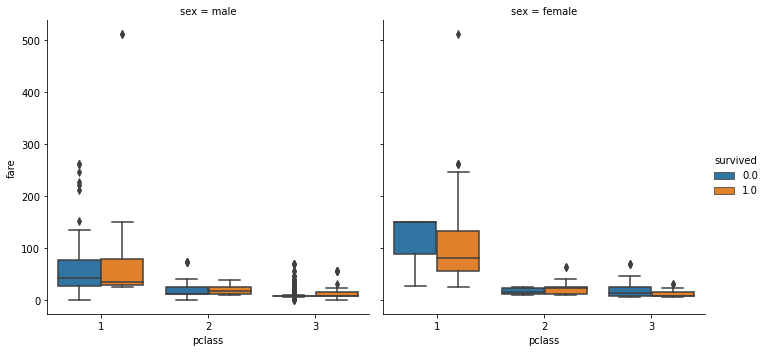

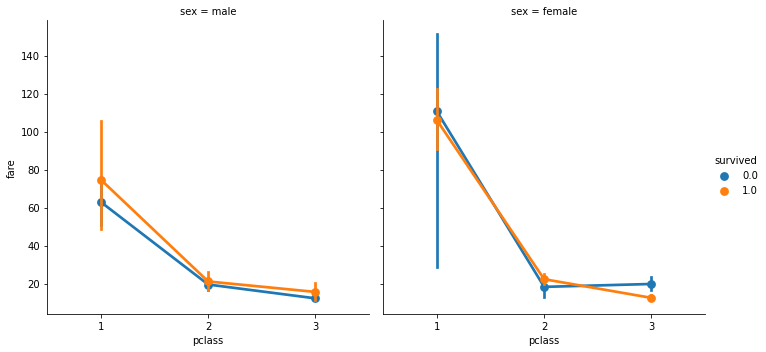

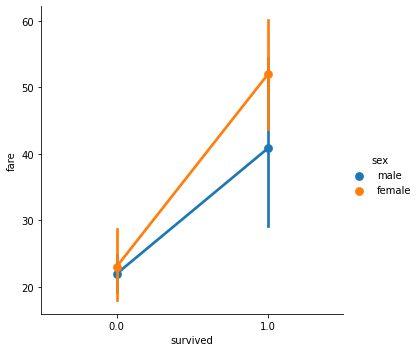

In [210]:
sns.catplot(x='pclass', y='fare', hue='survived', col='sex', data=training, kind='box')
sns.catplot(x='pclass', y='fare', hue='survived', col='sex', data=training, kind='point')
sns.catplot(x='survived', y='fare', hue='sex', data=training, kind='point')

After observing the close relationship between fare and class, it is not surprising that higher fares are associated with higher survivability. 

Another variable that will likely have some association with wealth is title.

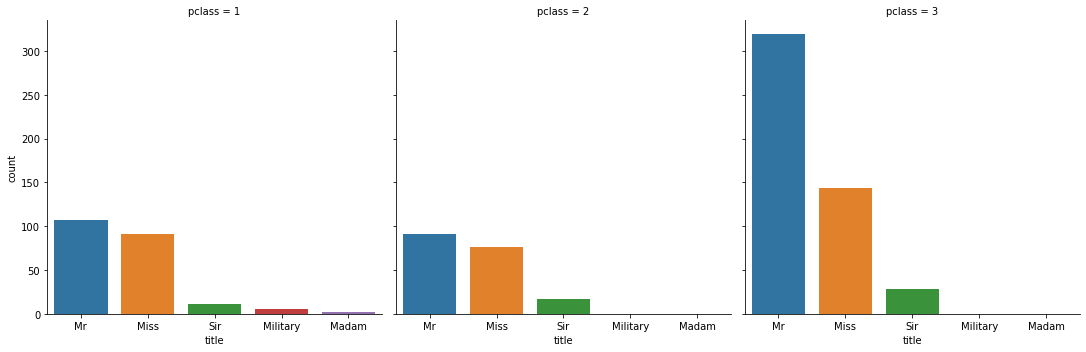

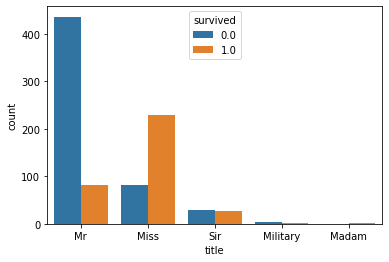

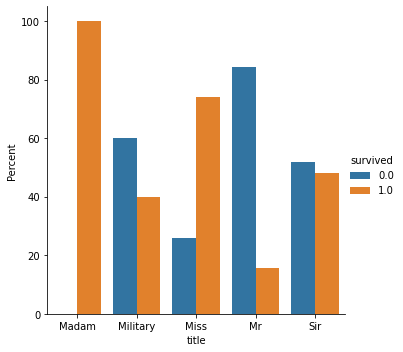

In [211]:
sns.catplot(x='title', col='pclass', data=training, kind='count')
plt.show()
sns.countplot(x='title', hue='survived', data=training)

(training
.groupby('title')['survived']
.value_counts(normalize=True)
.mul(100)
.rename('Percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='title',y='Percent',hue='survived',kind='bar'))

The pattern of wealth and higher chances of surviving continue with titles. Females continue to have a relatively high survival rate (>60%). Men just with 'Mr' have a low survivability rate, while 'Sirs' have a higher. Military title - a possible sign of members of the crew - have a survival rate of around 40%. 

One surprising point was that aside from 'Mr' having a high number of passenger in 3rd class even names with a signal of nobility (e.g. Sir) where fairly evenly split between classes.

The last variable we will look at is the one we created, family size.

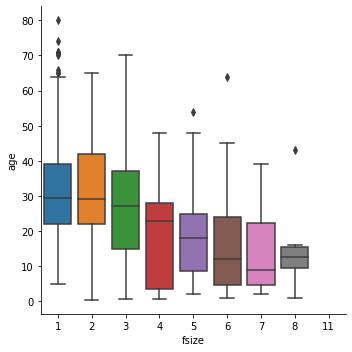

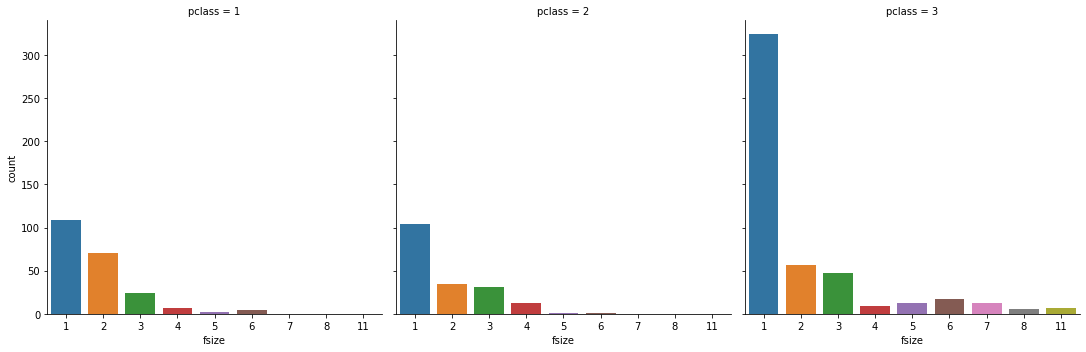

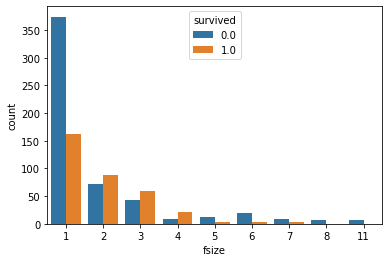

In [212]:
sns.catplot(x='fsize', y='age', data=training, kind='box')
plt.show()

sns.catplot(x='fsize', col='pclass', data=training, kind='count')
plt.show()

sns.countplot(x='fsize', hue='survived', data=training)

The age range for family sizes moves down, implying that larger families have more kids. Additionally, there does appear to be more families in third class. One unfortunate trend is that larger families still had still faced deaths even with their lower ages.

## 3. Model Building

I have decided to try 5 different models for this classification problem. We will train a K-nearest neighbors, a logistic regression (with an elastic net penalty), a random forest, a gradient boosted decision tree, and a support vector machine (one with a linear kernal and one with a polynomial kernel).

I will test each model with using a basic grid search for their parameters and use 5 cross-fold validation in an attempt to lower overfitting.

To start I will be predicting my target variable - 'survived' - with the predictor variables of: 'sex', 'fare', 'pclass', 'title', 'age_binned', and 'fsize.' At this point only age_binned is missing certain variables. I will use KNN imputation to fill in the missing data as it is slightly more robust than just using the median and/or mean. KNN imputation will factor in the family size, sex, passenger class, and fare to help predict the age for missing values.

In [213]:
# Create a training ID variable that contains the index of which observations will be used to train the model and which variables were used not to train the model
trainingid = full.training == True

full = full[['embarked', 'fare', 'pclass', 'sex', 'title', 'age_binned', 'fsize', 'survived']]

training = full[trainingid]
testing = full[~trainingid]

In [235]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

training_predictor = training.survived
training_feature = training.drop(columns=['survived'])

# Split variables between categorical (cat) and numerical (num)
training_feature_cat = ['embarked', 'sex', 'title', 'age_binned']
training_feature_num = ['fare', 'pclass', 'fsize']

# Create a preprocessing pipeline for categorical variables 
# Since the only variable with missing data at this point is 'age_binned' we only need to impute data in the categorical preprocessing pipeline
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('onehot', OneHotEncoder(categories='auto'))])

columnTransformer = ColumnTransformer([('cat', cat_pipe, training_feature_cat)], remainder='passthrough')

training_feature = np.array(columnTransformer.fit_transform(training_feature))

In [236]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_feature, training_predictor, test_size=0.3,
random_state=42, stratify=training_predictor)

In [237]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('preprocessing_2', StandardScaler()), 
                ('classifier', KNeighborsClassifier())])

param_grid = [
    {'classifier': [KNeighborsClassifier()], 'preprocessing_2': [StandardScaler(), None],
    'classifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]},
    {'classifier': [LogisticRegression(max_iter=50000)], 'preprocessing_2': [StandardScaler(), None],
    'classifier__C': [0.01,0.1,1,10,100,1000]},
    {'classifier': [LinearSVC()], 'preprocessing_2': [StandardScaler(), None],
    'classifier__C': [0.01,0.1,1,10,100,1000]},
    {'classifier': [RandomForestClassifier()], 'preprocessing_2': [StandardScaler(),None]},
    {'classifier': [GradientBoostingClassifier()], 'preprocessing_2': [StandardScaler(), None]}
]

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print('Best params:\n{}\n'.format(grid.best_params_))
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Test-set score: {:.2f}'.format(grid.score(X_test, y_test)))


/Users/Nick/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/Nick/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/Nick/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/Nick/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/Nick/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinea

Best params:
{'classifier': GradientBoostingClassifier(), 'preprocessing_2': StandardScaler()}

Best cross-validation score: 0.84
Test-set score: 0.81


In [238]:
gb = GradientBoostingClassifier()

gb_grid = {'learning_rate':[1, 0.5, 0.25, 0.125, 0.6, 0.3, 0.1, 0.01, 0.001], 
           'n_estimators':[25, 50, 75, 100, 125]}

gb_gs = GridSearchCV(gb, gb_grid, cv=5, scoring='accuracy')

gb_gs.fit(X_train, y_train)

print('Best params:\n{}\n'.format(gb_gs.best_params_))
print('Best cross-validation score: {:.2f}'.format(gb_gs.best_score_))
print('Test-set score: {:.2f}'.format(gb_gs.score(X_test, y_test)))

Best params:
{'learning_rate': 0.125, 'n_estimators': 50}

Best cross-validation score: 0.85
Test-set score: 0.82


In [242]:
training_predictor = training.survived
training_feature = training.drop(columns=['survived'])

training_feature_cat = ['embarked', 'sex', 'title', 'age_binned']
training_feature_num = ['fare', 'pclass', 'fsize']


cat_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('onehot', OneHotEncoder(categories='auto'))])

columnTransformer = ColumnTransformer([('cat', cat_pipe, training_feature_cat)])

best_gb = Pipeline(steps=[('preprocessor', columnTransformer),
                      ('classifier', GradientBoostingClassifier(learning_rate=0.25, n_estimators=50))])

best_gb.fit(training_feature, training_predictor)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['embarked', 'sex', 'title',
                                                   'age_binned'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.25,
                                            n_estimators=50))])

<BarContainer object of 20 artists>

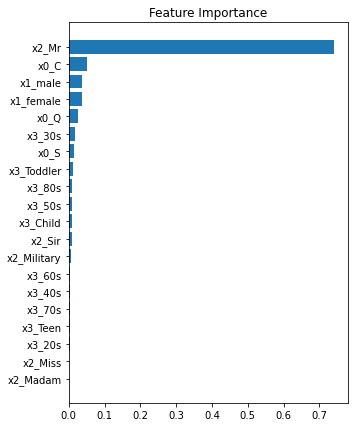

In [243]:
feature_names = best_gb['preprocessor'].transformers_[0][1]['onehot'].get_feature_names()
feature_importance = best_gb[1].feature_importances_

features_df = pd.DataFrame({'Features':feature_names, 'Importance':feature_importance})

features_df_sorted = features_df.sort_values('Importance')

plt.figure(figsize=(5,7))
plt.title('Feature Importance')
plt.barh(features_df_sorted.Features, features_df_sorted.Importance, align='center')

In [244]:
testing = testing.drop(columns='survived')
submission = best_gb.predict(testing)

In [257]:
submission = pd.DataFrame(data=submission, columns=['Survived'])
submission['PassengerId'] = [*range(892,1310)]
submission= submission[['PassengerId', 'Survived']]
submission.to_csv('submssion2.csv', index=False)